In [1]:
import pandas as pd  
import numpy as np  
import os
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

with suppress_stdout_stderr(): 
    from fbprophet import Prophet

In [4]:
states_url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_data = pd.read_csv(states_url) 
#us_url = 'https://covidtracking.com/api/v1/us/daily.csv'
#us_data = pd.read_csv(us_url)

# Clean US data of cases/deaths by state

In [5]:
states_data

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200828,AK,5923.0,333615.0,NaN,37.0,NaN,NaN,NaN,8.0,...,339538,0,0,3d717bff28ffd8829334a2576c131afe5a550a1a,0,0,0,0,0,NaN
1,20200828,AL,122185.0,842678.0,NaN,1002.0,14267.0,NaN,1450.0,NaN,...,964863,31,262,64b11813ba9a1d0f04a32f067a53266a0015df69,0,0,0,0,0,NaN
2,20200828,AR,59583.0,638472.0,NaN,407.0,4142.0,NaN,NaN,95.0,...,698055,17,38,0cf9891af09ae849e96cfcd456206ac4ea85ace1,0,0,0,0,0,NaN
3,20200828,AS,0.0,1514.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,71cf54a1af4aaba2ea5be34e0d5bcd25b20bea4b,0,0,0,0,0,NaN
4,20200828,AZ,200658.0,983419.0,NaN,809.0,21428.0,272.0,NaN,160.0,...,1184077,49,2,b6a4310291e6f2d45de519204f950abd7d77a207,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9892,20200126,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,d071f52c7b741eb47e42b29ec43d1fd5e5669698,0,0,0,0,0,NaN
9893,20200125,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,626988ec4dfe62f38d72dc25126a264411769056,0,0,0,0,0,NaN
9894,20200124,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6f40087f42d06db4121e09b184785b4110cd4df8,0,0,0,0,0,NaN
9895,20200123,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,978c05d8a7a9d46e9fa826d83215f5b9732f2c6d,0,0,0,0,0,NaN


Combine all positive cases and deaths for each state and date

In [6]:
deaths_project = states_data.groupby(['date','state'], as_index=False).sum()
deaths_project.rename(columns={'date':'ds', 'deathIncrease':'y'}, inplace=True)
deaths_project['ds'] = deaths_project['ds'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
deaths_project

,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResultsIncrease,posNeg,y,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,2020-01-22,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2020-01-23,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,2020-01-24,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
3,2020-01-25,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
4,2020-01-26,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9892,2020-08-28,VT,1589.0,125166.0,0.0,11.0,0.0,0.0,0.0,0.0,...,1924,126755,0,0,0,0,0,0,0,0.0
9893,2020-08-28,WA,72703.0,1335461.0,0.0,347.0,6674.0,0.0,0.0,45.0,...,16855,1408164,10,34,0,0,0,0,0,0.0
9894,2020-08-28,WI,78868.0,1156807.0,116.0,309.0,5736.0,103.0,1010.0,0.0,...,9177,1235675,2,52,0,0,0,0,0,0.0
9895,2020-08-28,WV,9824.0,409757.0,0.0,133.0,0.0,50.0,0.0,23.0,...,5772,419581,3,0,0,0,0,0,0,0.0


Create data frame with positive coronavirus increases and date for each state. This will be used to create regressor values in the Prophet model later.

In [7]:
columns = ['positiveIncrease', 'state', 'ds']
positiveIncrease_df = deaths_project[columns]
positiveIncrease_df

,positiveIncrease,state,ds
0,0,WA,2020-01-22
1,0,WA,2020-01-23
2,0,WA,2020-01-24
3,0,WA,2020-01-25
4,0,WA,2020-01-26
...,...,...,...
9892,3,VT,2020-08-28
9893,542,WA,2020-08-28
9894,864,WI,2020-08-28
9895,191,WV,2020-08-28


# Build Prophet Model

Covid-19 deaths is often described as a "lagging indicator" as it takes several weeks after diagnosis for patients to die. The Harvard School of Public Health demonstrated in a working paper that deaths often occur 2-8 weeks after the onset of Covid-19 symptoms.  

To account for this variable range in lag between cases and deaths, trophet Model will include a 7-day moving average reported positive coronavirus cases. This value is then pushed forward 35 days to compare deaths with the reported cases 5 weeks prior. 

In [8]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 7-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=7).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet()
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=35, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 35 days 
    future['Moving_Average'] = future['Moving_Average'].shift(35)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  111.0               0.0    AK        0.000000
1   2020-03-07  147.0               0.0    AK        0.000000
2   2020-03-08  197.0               0.0    AK        0.000000
3   2020-03-09  247.0               0.0    AK        0.000000
4   2020-03-10  297.0               0.0    AK        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN       74.000000
207 2020-09-29    NaN               NaN   NaN       69.857143
208 2020-09-30    NaN               NaN   NaN       67.428571
209 2020-10-01    NaN               NaN   NaN       67.000000
210 2020-10-02    NaN               NaN   NaN       74.285714

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  148.0               0.0    AL        0.000000
1   2020-03-08  198.0               0.0    AL        0.000000
2   2020-03-09  248.0               0.0    AL        0.000000
3   2020-03-10  298.0               0.0    AL        0.000000
4   2020-03-11  348.0               0.0    AL        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN     1100.857143
206 2020-09-29    NaN               NaN   NaN      983.000000
207 2020-09-30    NaN               NaN   NaN     1110.857143
208 2020-10-01    NaN               NaN   NaN     1224.857143
209 2020-10-02    NaN               NaN   NaN     1345.000000

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  112.0               0.0    AR        0.000000
1   2020-03-07  149.0               0.0    AR        0.000000
2   2020-03-08  199.0               0.0    AR        0.000000
3   2020-03-09  249.0               0.0    AR        0.000000
4   2020-03-10  299.0               0.0    AR        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      545.285714
207 2020-09-29    NaN               NaN   NaN      555.285714
208 2020-09-30    NaN               NaN   NaN      543.857143
209 2020-10-01    NaN               NaN   NaN      568.571429
210 2020-10-02    NaN               NaN   NaN      561.571429

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-16  604.0               0.0    AS             0.0
1   2020-03-17  660.0               0.0    AS             0.0
2   2020-03-18  716.0               0.0    AS             0.0
3   2020-03-19  772.0               0.0    AS             0.0
4   2020-03-20  828.0               0.0    AS             0.0
..         ...    ...               ...   ...             ...
196 2020-09-28    NaN               NaN   NaN             0.0
197 2020-09-29    NaN               NaN   NaN             0.0
198 2020-09-30    NaN               NaN   NaN             0.0
199 2020-10-01    NaN               NaN   NaN             0.0
200 2020-10-02    NaN               NaN   NaN             0.0

[201 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   71.0               0.0    AZ        0.000000
1   2020-03-05   87.0               0.0    AZ        0.000000
2   2020-03-06  113.0               1.0    AZ        0.000000
3   2020-03-07  150.0               2.0    AZ        0.000000
4   2020-03-08  200.0               0.0    AZ        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN      629.857143
209 2020-09-29    NaN               NaN   NaN      621.857143
210 2020-09-30    NaN               NaN   NaN      557.428571
211 2020-10-01    NaN               NaN   NaN      551.285714
212 2020-10-02    NaN               NaN   NaN      537.000000

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   72.0               0.0    CA        0.000000
1   2020-03-05   88.0               0.0    CA        0.000000
2   2020-03-06  114.0               7.0    CA        0.000000
3   2020-03-07  151.0               9.0    CA        0.000000
4   2020-03-08  201.0              19.0    CA        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     5797.714286
209 2020-09-29    NaN               NaN   NaN     5775.428571
210 2020-09-30    NaN               NaN   NaN     5752.571429
211 2020-10-01    NaN               NaN   NaN     5539.714286
212 2020-10-02    NaN               NaN   NaN     5503.142857

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05   89.0               0.0    CO        0.000000
1   2020-03-06  115.0               2.0    CO        0.000000
2   2020-03-07  152.0               6.0    CO        0.000000
3   2020-03-08  202.0               0.0    CO        0.000000
4   2020-03-09  252.0               1.0    CO        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      281.000000
208 2020-09-29    NaN               NaN   NaN      281.571429
209 2020-09-30    NaN               NaN   NaN      309.857143
210 2020-10-01    NaN               NaN   NaN      298.857143
211 2020-10-02    NaN               NaN   NaN      301.857143

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  153.0               0.0    CT        0.000000
1   2020-03-08  203.0               1.0    CT        0.000000
2   2020-03-09  253.0               0.0    CT        0.000000
3   2020-03-10  303.0               1.0    CT        0.000000
4   2020-03-11  353.0               1.0    CT        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      106.285714
206 2020-09-29    NaN               NaN   NaN      112.142857
207 2020-09-30    NaN               NaN   NaN      129.428571
208 2020-10-01    NaN               NaN   NaN      131.142857
209 2020-10-02    NaN               NaN   NaN      139.428571

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05   90.0               0.0    DC        0.000000
1   2020-03-06  116.0               0.0    DC        0.000000
2   2020-03-07  154.0               0.0    DC        0.000000
3   2020-03-08  204.0               1.0    DC        0.000000
4   2020-03-09  254.0               0.0    DC        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN       52.285714
208 2020-09-29    NaN               NaN   NaN       51.285714
209 2020-09-30    NaN               NaN   NaN       52.571429
210 2020-10-01    NaN               NaN   NaN       55.000000
211 2020-10-02    NaN               NaN   NaN       54.571429

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  117.0               0.0    DE        0.000000
1   2020-03-07  155.0               0.0    DE        0.000000
2   2020-03-08  205.0               0.0    DE        0.000000
3   2020-03-09  255.0               0.0    DE        0.000000
4   2020-03-10  305.0               0.0    DE        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN       58.000000
207 2020-09-29    NaN               NaN   NaN       52.714286
208 2020-09-30    NaN               NaN   NaN       49.000000
209 2020-10-01    NaN               NaN   NaN       36.857143
210 2020-10-02    NaN               NaN   NaN       44.714286

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   73.0               0.0    FL        0.000000
1   2020-03-05   91.0               7.0    FL        0.000000
2   2020-03-06  118.0               0.0    FL        0.000000
3   2020-03-07  156.0               5.0    FL        0.000000
4   2020-03-08  206.0               3.0    FL        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     3819.285714
209 2020-09-29    NaN               NaN   NaN     3652.857143
210 2020-09-30    NaN               NaN   NaN     3525.000000
211 2020-10-01    NaN               NaN   NaN     3341.285714
212 2020-10-02    NaN               NaN   NaN     3217.142857

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   74.0               0.0    GA        0.000000
1   2020-03-05   92.0               0.0    GA        0.000000
2   2020-03-06  119.0               0.0    GA        0.000000
3   2020-03-07  157.0               4.0    GA        0.000000
4   2020-03-08  207.0               1.0    GA        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     2484.571429
209 2020-09-29    NaN               NaN   NaN     2382.428571
210 2020-09-30    NaN               NaN   NaN     2372.571429
211 2020-10-01    NaN               NaN   NaN     2333.285714
212 2020-10-02    NaN               NaN   NaN     2248.857143

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-16  613.0               0.0    GU        0.000000
1   2020-03-17  669.0               2.0    GU        0.000000
2   2020-03-18  725.0               3.0    GU        0.000000
3   2020-03-19  781.0               4.0    GU        0.000000
4   2020-03-20  837.0               2.0    GU        0.000000
..         ...    ...               ...   ...             ...
196 2020-09-28    NaN               NaN   NaN       49.857143
197 2020-09-29    NaN               NaN   NaN       58.142857
198 2020-09-30    NaN               NaN   NaN       74.428571
199 2020-10-01    NaN               NaN   NaN       75.428571
200 2020-10-02    NaN               NaN   NaN       74.285714

[201 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  158.0               0.0    HI        0.000000
1   2020-03-08  208.0               0.0    HI        0.000000
2   2020-03-09  258.0               1.0    HI        0.000000
3   2020-03-10  308.0               0.0    HI        0.000000
4   2020-03-11  358.0               0.0    HI        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      222.571429
206 2020-09-29    NaN               NaN   NaN      252.714286
207 2020-09-30    NaN               NaN   NaN      196.428571
208 2020-10-01    NaN               NaN   NaN      202.285714
209 2020-10-02    NaN               NaN   NaN      246.000000

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  120.0               0.0    IA        0.000000
1   2020-03-07  159.0               0.0    IA        0.000000
2   2020-03-08  209.0               0.0    IA        0.000000
3   2020-03-09  259.0               3.0    IA        0.000000
4   2020-03-10  309.0               5.0    IA        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      558.714286
207 2020-09-29    NaN               NaN   NaN      620.428571
208 2020-09-30    NaN               NaN   NaN      706.714286
209 2020-10-01    NaN               NaN   NaN      824.428571
210 2020-10-02    NaN               NaN   NaN      852.142857

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  160.0               0.0    ID        0.000000
1   2020-03-08  210.0               0.0    ID        0.000000
2   2020-03-09  260.0               0.0    ID        0.000000
3   2020-03-10  310.0               0.0    ID        0.000000
4   2020-03-11  360.0               0.0    ID        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      313.285714
206 2020-09-29    NaN               NaN   NaN      304.000000
207 2020-09-30    NaN               NaN   NaN      307.000000
208 2020-10-01    NaN               NaN   NaN      297.714286
209 2020-10-02    NaN               NaN   NaN      286.000000

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   75.0               0.0    IL        0.000000
1   2020-03-05   93.0               1.0    IL        0.000000
2   2020-03-06  121.0               0.0    IL        0.000000
3   2020-03-07  161.0               1.0    IL        0.000000
4   2020-03-08  211.0               0.0    IL        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     2003.000000
209 2020-09-29    NaN               NaN   NaN     1994.428571
210 2020-09-30    NaN               NaN   NaN     1974.714286
211 2020-10-01    NaN               NaN   NaN     1956.857143
212 2020-10-02    NaN               NaN   NaN     1977.000000

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  122.0               0.0    IN        0.000000
1   2020-03-07  162.0               0.0    IN        0.000000
2   2020-03-08  212.0               1.0    IN        0.000000
3   2020-03-09  262.0               0.0    IN        0.000000
4   2020-03-10  312.0               4.0    IN        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      940.857143
207 2020-09-29    NaN               NaN   NaN      939.142857
208 2020-09-30    NaN               NaN   NaN     1003.285714
209 2020-10-01    NaN               NaN   NaN     1032.428571
210 2020-10-02    NaN               NaN   NaN      999.428571

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  123.0               0.0    KS        0.000000
1   2020-03-07  163.0               0.0    KS        0.000000
2   2020-03-08  213.0               1.0    KS        0.000000
3   2020-03-09  263.0               0.0    KS        0.000000
4   2020-03-10  313.0               0.0    KS        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      462.000000
207 2020-09-29    NaN               NaN   NaN      462.000000
208 2020-09-30    NaN               NaN   NaN      578.142857
209 2020-10-01    NaN               NaN   NaN      578.142857
210 2020-10-02    NaN               NaN   NaN      598.857143

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  124.0               0.0    KY        0.000000
1   2020-03-07  164.0               1.0    KY        0.000000
2   2020-03-08  214.0               0.0    KY        0.000000
3   2020-03-09  264.0               3.0    KY        0.000000
4   2020-03-10  314.0               2.0    KY        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      601.142857
207 2020-09-29    NaN               NaN   NaN      609.857143
208 2020-09-30    NaN               NaN   NaN      614.857143
209 2020-10-01    NaN               NaN   NaN      621.714286
210 2020-10-02    NaN               NaN   NaN      641.714286

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  165.0               0.0    LA        0.000000
1   2020-03-08  215.0               0.0    LA        0.000000
2   2020-03-09  265.0               1.0    LA        0.000000
3   2020-03-10  315.0               0.0    LA        0.000000
4   2020-03-11  365.0               5.0    LA        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      725.857143
206 2020-09-29    NaN               NaN   NaN      713.000000
207 2020-09-30    NaN               NaN   NaN      722.428571
208 2020-10-01    NaN               NaN   NaN      688.000000
209 2020-10-02    NaN               NaN   NaN      646.142857

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-12  416.0               0.0    MA        0.000000
1   2020-03-13  467.0              15.0    MA        0.000000
2   2020-03-14  518.0              15.0    MA        0.000000
3   2020-03-15  569.0              26.0    MA        0.000000
4   2020-03-16  622.0              33.0    MA        0.000000
..         ...    ...               ...   ...             ...
200 2020-09-28    NaN               NaN   NaN      372.714286
201 2020-09-29    NaN               NaN   NaN      404.571429
202 2020-09-30    NaN               NaN   NaN      334.428571
203 2020-10-01    NaN               NaN   NaN      342.285714
204 2020-10-02    NaN               NaN   NaN      338.285714

[205 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05   94.0               0.0    MD        0.000000
1   2020-03-06  125.0               3.0    MD        0.000000
2   2020-03-07  166.0               0.0    MD        0.000000
3   2020-03-08  216.0               0.0    MD        0.000000
4   2020-03-09  266.0               2.0    MD        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      564.857143
208 2020-09-29    NaN               NaN   NaN      544.428571
209 2020-09-30    NaN               NaN   NaN      548.142857
210 2020-10-01    NaN               NaN   NaN      547.714286
211 2020-10-02    NaN               NaN   NaN      537.857143

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  167.0               0.0    ME        0.000000
1   2020-03-08  217.0               0.0    ME        0.000000
2   2020-03-09  267.0               0.0    ME        0.000000
3   2020-03-10  317.0               0.0    ME        0.000000
4   2020-03-11  367.0               0.0    ME        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN       22.714286
206 2020-09-29    NaN               NaN   NaN       22.142857
207 2020-09-30    NaN               NaN   NaN       22.142857
208 2020-10-01    NaN               NaN   NaN       23.000000
209 2020-10-02    NaN               NaN   NaN       21.571429

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-01   59.0               0.0    MI        0.000000
1   2020-03-02   63.0               9.0    MI        0.000000
2   2020-03-03   67.0              16.0    MI        0.000000
3   2020-03-04   76.0              18.0    MI        0.000000
4   2020-03-05   95.0              20.0    MI        0.000000
..         ...    ...               ...   ...             ...
211 2020-09-28    NaN               NaN   NaN      705.285714
212 2020-09-29    NaN               NaN   NaN      747.714286
213 2020-09-30    NaN               NaN   NaN      769.857143
214 2020-10-01    NaN               NaN   NaN      817.857143
215 2020-10-02    NaN               NaN   NaN      931.142857

[216 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  127.0               0.0    MN        0.000000
1   2020-03-07  169.0               1.0    MN        0.000000
2   2020-03-08  219.0               0.0    MN        0.000000
3   2020-03-09  269.0               3.0    MN        0.000000
4   2020-03-10  319.0               6.0    MN        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      654.571429
207 2020-09-29    NaN               NaN   NaN      663.714286
208 2020-09-30    NaN               NaN   NaN      659.714286
209 2020-10-01    NaN               NaN   NaN      726.000000
210 2020-10-02    NaN               NaN   NaN      729.571429

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  170.0               0.0    MO        0.000000
1   2020-03-08  220.0               1.0    MO        0.000000
2   2020-03-09  270.0               0.0    MO        0.000000
3   2020-03-10  320.0               0.0    MO        0.000000
4   2020-03-11  370.0               0.0    MO        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN     1045.857143
206 2020-09-29    NaN               NaN   NaN     1031.285714
207 2020-09-30    NaN               NaN   NaN     1055.285714
208 2020-10-01    NaN               NaN   NaN     1120.142857
209 2020-10-02    NaN               NaN   NaN     1146.857143

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-16  628.0               0.0    MP        0.000000
1   2020-03-17  684.0               0.0    MP        0.000000
2   2020-03-18  740.0               0.0    MP        0.000000
3   2020-03-19  796.0               0.0    MP        0.000000
4   2020-03-20  852.0               0.0    MP        0.000000
..         ...    ...               ...   ...             ...
196 2020-09-28    NaN               NaN   NaN        0.142857
197 2020-09-29    NaN               NaN   NaN        0.000000
198 2020-09-30    NaN               NaN   NaN        0.000000
199 2020-10-01    NaN               NaN   NaN        0.000000
200 2020-10-02    NaN               NaN   NaN        0.000000

[201 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  171.0               0.0    MS        0.000000
1   2020-03-08  221.0               0.0    MS        0.000000
2   2020-03-09  271.0               0.0    MS        0.000000
3   2020-03-10  321.0               0.0    MS        0.000000
4   2020-03-11  371.0               0.0    MS        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      856.142857
206 2020-09-29    NaN               NaN   NaN      857.000000
207 2020-09-30    NaN               NaN   NaN      793.571429
208 2020-10-01    NaN               NaN   NaN      749.428571
209 2020-10-02    NaN               NaN   NaN      710.142857

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  172.0               0.0    MT        0.000000
1   2020-03-08  222.0               0.0    MT        0.000000
2   2020-03-09  272.0               0.0    MT        0.000000
3   2020-03-10  322.0               0.0    MT        0.000000
4   2020-03-11  372.0               0.0    MT        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN       99.571429
206 2020-09-29    NaN               NaN   NaN      111.142857
207 2020-09-30    NaN               NaN   NaN      118.428571
208 2020-10-01    NaN               NaN   NaN      122.428571
209 2020-10-02    NaN               NaN   NaN      121.000000

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   77.0               0.0    NC        0.000000
1   2020-03-05   96.0               0.0    NC        0.000000
2   2020-03-06  128.0               1.0    NC        0.000000
3   2020-03-07  173.0               0.0    NC        0.000000
4   2020-03-08  223.0               0.0    NC        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     1554.285714
209 2020-09-29    NaN               NaN   NaN     1566.000000
210 2020-09-30    NaN               NaN   NaN     1579.000000
211 2020-10-01    NaN               NaN   NaN     1596.000000
212 2020-10-02    NaN               NaN   NaN     1511.285714

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  174.0               0.0    ND        0.000000
1   2020-03-08  224.0               0.0    ND        0.000000
2   2020-03-09  274.0               0.0    ND        0.000000
3   2020-03-10  324.0               0.0    ND        0.000000
4   2020-03-11  374.0               0.0    ND        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      193.285714
206 2020-09-29    NaN               NaN   NaN      206.714286
207 2020-09-30    NaN               NaN   NaN      214.142857
208 2020-10-01    NaN               NaN   NaN      222.571429
209 2020-10-02    NaN               NaN   NaN      233.714286

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05   97.0               0.0    NE        0.000000
1   2020-03-06  129.0               0.0    NE        0.000000
2   2020-03-07  175.0               1.0    NE        0.000000
3   2020-03-08  225.0               0.0    NE        0.000000
4   2020-03-09  275.0               2.0    NE        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      216.714286
208 2020-09-29    NaN               NaN   NaN      212.000000
209 2020-09-30    NaN               NaN   NaN      217.571429
210 2020-10-01    NaN               NaN   NaN      241.000000
211 2020-10-02    NaN               NaN   NaN      250.428571

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   78.0               0.0    NH        0.000000
1   2020-03-05   98.0               0.0    NH        0.000000
2   2020-03-06  130.0               0.0    NH        0.000000
3   2020-03-07  176.0               0.0    NH        0.000000
4   2020-03-08  226.0               2.0    NH        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN       18.571429
209 2020-09-29    NaN               NaN   NaN       19.000000
210 2020-09-30    NaN               NaN   NaN       17.571429
211 2020-10-01    NaN               NaN   NaN       20.571429
212 2020-10-02    NaN               NaN   NaN       23.714286

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-02-10   19.0               0.0    NJ        0.000000
1   2020-02-11   21.0               0.0    NJ        0.000000
2   2020-02-12   23.0               0.0    NJ        0.000000
3   2020-02-13   25.0               0.0    NJ        0.000000
4   2020-02-14   27.0               0.0    NJ        0.000000
..         ...    ...               ...   ...             ...
231 2020-09-28    NaN               NaN   NaN      278.857143
232 2020-09-29    NaN               NaN   NaN      274.714286
233 2020-09-30    NaN               NaN   NaN      268.428571
234 2020-10-01    NaN               NaN   NaN      298.000000
235 2020-10-02    NaN               NaN   NaN      307.714286

[236 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  132.0               0.0    NM        0.000000
1   2020-03-07  178.0               0.0    NM        0.000000
2   2020-03-08  228.0               0.0    NM        0.000000
3   2020-03-09  278.0               0.0    NM        0.000000
4   2020-03-10  328.0               0.0    NM        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      141.142857
207 2020-09-29    NaN               NaN   NaN      138.428571
208 2020-09-30    NaN               NaN   NaN      136.571429
209 2020-10-01    NaN               NaN   NaN      140.428571
210 2020-10-02    NaN               NaN   NaN      138.428571

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05  100.0               0.0    NV        0.000000
1   2020-03-06  133.0               0.0    NV        0.000000
2   2020-03-07  179.0               0.0    NV        0.000000
3   2020-03-08  229.0               0.0    NV        0.000000
4   2020-03-09  279.0               0.0    NV        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      577.571429
208 2020-09-29    NaN               NaN   NaN      539.142857
209 2020-09-30    NaN               NaN   NaN      519.714286
210 2020-10-01    NaN               NaN   NaN      519.428571
211 2020-10-02    NaN               NaN   NaN      488.428571

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   80.0               0.0    NY        0.000000
1   2020-03-05  101.0              16.0    NY        0.000000
2   2020-03-06  134.0              11.0    NY        0.000000
3   2020-03-07  180.0              43.0    NY        0.000000
4   2020-03-08  230.0              29.0    NY        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN      604.142857
209 2020-09-29    NaN               NaN   NaN      600.428571
210 2020-09-30    NaN               NaN   NaN      591.142857
211 2020-10-01    NaN               NaN   NaN      618.285714
212 2020-10-02    NaN               NaN   NaN      607.857143

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05  102.0               0.0    OH        0.000000
1   2020-03-06  135.0               0.0    OH        0.000000
2   2020-03-07  181.0               0.0    OH        0.000000
3   2020-03-08  231.0               0.0    OH        0.000000
4   2020-03-09  281.0               3.0    OH        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      941.285714
208 2020-09-29    NaN               NaN   NaN      938.857143
209 2020-09-30    NaN               NaN   NaN      957.571429
210 2020-10-01    NaN               NaN   NaN      975.000000
211 2020-10-02    NaN               NaN   NaN     1011.142857

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  182.0               0.0    OK        0.000000
1   2020-03-08  232.0               0.0    OK        0.000000
2   2020-03-09  282.0               0.0    OK        0.000000
3   2020-03-10  332.0               1.0    OK        0.000000
4   2020-03-11  382.0               0.0    OK        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      687.285714
206 2020-09-29    NaN               NaN   NaN      692.285714
207 2020-09-30    NaN               NaN   NaN      702.142857
208 2020-10-01    NaN               NaN   NaN      697.285714
209 2020-10-02    NaN               NaN   NaN      644.857143

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   81.0               0.0    OR        0.000000
1   2020-03-05  103.0               0.0    OR        0.000000
2   2020-03-06  136.0               0.0    OR        0.000000
3   2020-03-07  183.0               4.0    OR        0.000000
4   2020-03-08  233.0               7.0    OR        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN      243.428571
209 2020-09-29    NaN               NaN   NaN      245.000000
210 2020-09-30    NaN               NaN   NaN      243.000000
211 2020-10-01    NaN               NaN   NaN      228.000000
212 2020-10-02    NaN               NaN   NaN      233.285714

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  137.0               0.0    PA        0.000000
1   2020-03-07  184.0               2.0    PA        0.000000
2   2020-03-08  234.0               2.0    PA        0.000000
3   2020-03-09  284.0               4.0    PA        0.000000
4   2020-03-10  334.0               2.0    PA        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN      661.428571
207 2020-09-29    NaN               NaN   NaN      636.571429
208 2020-09-30    NaN               NaN   NaN      626.714286
209 2020-10-01    NaN               NaN   NaN      602.285714
210 2020-10-02    NaN               NaN   NaN      622.571429

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-16  643.0               0.0    PR        0.000000
1   2020-03-17  699.0               0.0    PR        0.000000
2   2020-03-18  755.0               0.0    PR        0.000000
3   2020-03-19  811.0               0.0    PR        0.000000
4   2020-03-20  867.0               9.0    PR        0.000000
..         ...    ...               ...   ...             ...
196 2020-09-28    NaN               NaN   NaN      551.142857
197 2020-09-29    NaN               NaN   NaN      429.571429
198 2020-09-30    NaN               NaN   NaN      401.428571
199 2020-10-01    NaN               NaN   NaN      462.857143
200 2020-10-02    NaN               NaN   NaN      448.857143

[201 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-01   61.0               0.0    RI        0.000000
1   2020-03-02   65.0               0.0    RI        0.000000
2   2020-03-03   69.0               0.0    RI        0.000000
3   2020-03-04   82.0               0.0    RI        0.000000
4   2020-03-05  104.0               1.0    RI        0.000000
..         ...    ...               ...   ...             ...
211 2020-09-28    NaN               NaN   NaN      104.285714
212 2020-09-29    NaN               NaN   NaN       97.142857
213 2020-09-30    NaN               NaN   NaN       94.142857
214 2020-10-01    NaN               NaN   NaN      102.571429
215 2020-10-02    NaN               NaN   NaN       94.428571

[216 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   83.0               0.0    SC        0.000000
1   2020-03-05  105.0               0.0    SC        0.000000
2   2020-03-06  139.0               0.0    SC        0.000000
3   2020-03-07  186.0               2.0    SC        0.000000
4   2020-03-08  236.0               0.0    SC        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN      799.714286
209 2020-09-29    NaN               NaN   NaN      830.857143
210 2020-09-30    NaN               NaN   NaN      811.714286
211 2020-10-01    NaN               NaN   NaN      754.000000
212 2020-10-02    NaN               NaN   NaN      796.142857

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  187.0               0.0    SD        0.000000
1   2020-03-08  237.0               0.0    SD        0.000000
2   2020-03-09  287.0               0.0    SD        0.000000
3   2020-03-10  337.0               0.0    SD        0.000000
4   2020-03-11  387.0               5.0    SD        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      152.142857
206 2020-09-29    NaN               NaN   NaN      159.428571
207 2020-09-30    NaN               NaN   NaN      183.571429
208 2020-10-01    NaN               NaN   NaN      214.714286
209 2020-10-02    NaN               NaN   NaN      233.285714

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05  106.0               0.0    TN        0.000000
1   2020-03-06  140.0               0.0    TN        0.000000
2   2020-03-07  188.0               0.0    TN        0.000000
3   2020-03-08  238.0               2.0    TN        0.000000
4   2020-03-09  288.0               0.0    TN        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN     1408.571429
208 2020-09-29    NaN               NaN   NaN     1377.000000
209 2020-09-30    NaN               NaN   NaN     1364.714286
210 2020-10-01    NaN               NaN   NaN     1429.142857
211 2020-10-02    NaN               NaN   NaN     1424.428571

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   84.0               0.0    TX        0.000000
1   2020-03-05  107.0               0.0    TX        0.000000
2   2020-03-06  141.0               4.0    TX        0.000000
3   2020-03-07  189.0               3.0    TX        0.000000
4   2020-03-08  239.0               0.0    TX        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN     5347.714286
209 2020-09-29    NaN               NaN   NaN     5214.000000
210 2020-09-30    NaN               NaN   NaN     4983.000000
211 2020-10-01    NaN               NaN   NaN     5025.428571
212 2020-10-02    NaN               NaN   NaN     4884.000000

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  190.0               0.0    UT        0.000000
1   2020-03-08  240.0               0.0    UT        0.000000
2   2020-03-09  290.0               0.0    UT        0.000000
3   2020-03-10  340.0               1.0    UT        0.000000
4   2020-03-11  390.0               0.0    UT        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN      352.857143
206 2020-09-29    NaN               NaN   NaN      372.857143
207 2020-09-30    NaN               NaN   NaN      379.000000
208 2020-10-01    NaN               NaN   NaN      367.857143
209 2020-10-02    NaN               NaN   NaN      357.571429

[210 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-05  108.0               0.0    VA        0.000000
1   2020-03-06  142.0               0.0    VA        0.000000
2   2020-03-07  191.0               0.0    VA        0.000000
3   2020-03-08  241.0               2.0    VA        0.000000
4   2020-03-09  291.0               1.0    VA        0.000000
..         ...    ...               ...   ...             ...
207 2020-09-28    NaN               NaN   NaN      887.000000
208 2020-09-29    NaN               NaN   NaN      907.571429
209 2020-09-30    NaN               NaN   NaN      919.857143
210 2020-10-01    NaN               NaN   NaN      796.571429
211 2020-10-02    NaN               NaN   NaN      961.714286

[212 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-16  651.0               0.0    VI        0.000000
1   2020-03-17  707.0               1.0    VI        0.000000
2   2020-03-18  763.0               0.0    VI        0.000000
3   2020-03-19  819.0               1.0    VI        0.000000
4   2020-03-20  875.0               0.0    VI        0.000000
..         ...    ...               ...   ...             ...
196 2020-09-28    NaN               NaN   NaN       32.000000
197 2020-09-29    NaN               NaN   NaN       28.857143
198 2020-09-30    NaN               NaN   NaN       28.857143
199 2020-10-01    NaN               NaN   NaN       26.142857
200 2020-10-02    NaN               NaN   NaN       20.428571

[201 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  143.0               0.0    VT        0.000000
1   2020-03-07  192.0               1.0    VT        0.000000
2   2020-03-08  242.0               0.0    VT        0.000000
3   2020-03-09  292.0               0.0    VT        0.000000
4   2020-03-10  342.0               0.0    VT        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN        5.571429
207 2020-09-29    NaN               NaN   NaN        6.000000
208 2020-09-30    NaN               NaN   NaN        6.285714
209 2020-10-01    NaN               NaN   NaN        7.000000
210 2020-10-02    NaN               NaN   NaN        6.857143

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-01-22    0.0               0.0    WA        0.000000
1   2020-01-23    1.0               0.0    WA        0.000000
2   2020-01-24    2.0               0.0    WA        0.000000
3   2020-01-25    3.0               0.0    WA        0.000000
4   2020-01-26    4.0               0.0    WA        0.000000
..         ...    ...               ...   ...             ...
250 2020-09-28    NaN               NaN   NaN      330.285714
251 2020-09-29    NaN               NaN   NaN      244.857143
252 2020-09-30    NaN               NaN   NaN      167.857143
253 2020-10-01    NaN               NaN   NaN      169.714286
254 2020-10-02    NaN               NaN   NaN      184.142857

[255 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-04   86.0               0.0    WI        0.000000
1   2020-03-05  110.0               0.0    WI        0.000000
2   2020-03-06  145.0               0.0    WI        0.000000
3   2020-03-07  194.0               0.0    WI        0.000000
4   2020-03-08  244.0               0.0    WI        0.000000
..         ...    ...               ...   ...             ...
208 2020-09-28    NaN               NaN   NaN      700.571429
209 2020-09-29    NaN               NaN   NaN      697.428571
210 2020-09-30    NaN               NaN   NaN      708.285714
211 2020-10-01    NaN               NaN   NaN      728.714286
212 2020-10-02    NaN               NaN   NaN      731.000000

[213 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-06  146.0               0.0    WV        0.000000
1   2020-03-07  195.0               0.0    WV        0.000000
2   2020-03-08  245.0               0.0    WV        0.000000
3   2020-03-09  295.0               0.0    WV        0.000000
4   2020-03-10  345.0               0.0    WV        0.000000
..         ...    ...               ...   ...             ...
206 2020-09-28    NaN               NaN   NaN       97.142857
207 2020-09-29    NaN               NaN   NaN       94.857143
208 2020-09-30    NaN               NaN   NaN      105.571429
209 2020-10-01    NaN               NaN   NaN       93.000000
210 2020-10-02    NaN               NaN   NaN      108.285714

[211 rows x 5 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds  index  positiveIncrease state  Moving_Average
0   2020-03-07  196.0               0.0    WY        0.000000
1   2020-03-08  246.0               0.0    WY        0.000000
2   2020-03-09  296.0               0.0    WY        0.000000
3   2020-03-10  346.0               0.0    WY        0.000000
4   2020-03-11  396.0               0.0    WY        0.000000
..         ...    ...               ...   ...             ...
205 2020-09-28    NaN               NaN   NaN       38.857143
206 2020-09-29    NaN               NaN   NaN       38.714286
207 2020-09-30    NaN               NaN   NaN       36.285714
208 2020-10-01    NaN               NaN   NaN       36.285714
209 2020-10-02    NaN               NaN   NaN       34.142857

[210 rows x 5 columns]


[[]]

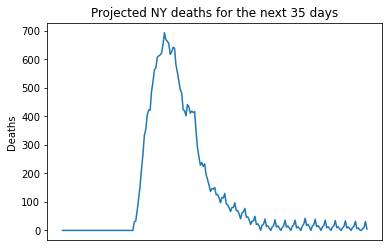

In [9]:
deaths_project_df[deaths_project_df < 0] = 0
deaths_project_df.reset_index(level=0, inplace=True)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_df)
ax.set_title('Projected NY deaths for the next 35 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

Due to how deaths are reported, the graphs are often oscillating with the crest occuring mid-week and trough on the weekends. To smooth the graph, the 7-day moving average will be calculated

[[]]

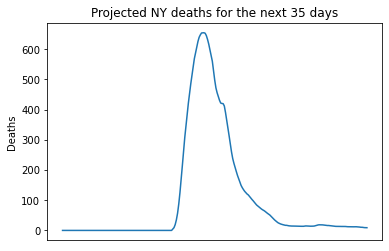

In [10]:
#Create 7-day moving average to smooth graph
deaths_project_FINAL = deaths_project_df
deaths_project_FINAL = deaths_project_FINAL.fillna(0)
deaths_project_FINAL = deaths_project_FINAL.set_index('ds')
deaths_project_FINAL = deaths_project_FINAL.rolling(window=7).mean()
deaths_project_FINAL = deaths_project_FINAL.reset_index()
deaths_project_FINAL = deaths_project_FINAL.fillna(0)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_FINAL)
ax.set_title('Projected NY deaths for the next 35 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

In [33]:
#Transform = deaths_project_FINAL.T
#new_header = Transform.iloc[0] #grab the first row for the header
#Transform = Transform[1:] #take the data less the header row
#Transform.columns = new_header #set the header row as the df header
#Transform = Transform.reset_index()
#Transform['index']= Transform['index'].str.split('_', n = 1, expand = True)[1]
#Transform

# Export to google sheets API

In [11]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

In [12]:
scope = ["https://spreadsheets.google.com/feeds","https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name("covid-project-286507-4067516cf92b.json", scopes=scope)
gc = gspread.authorize(credentials)
spreadsheet_key= "1O86g7PnDxIYn9kpC_LA9DuC56rB_A-deUo1LtltRFOo"

In [13]:
wks_name = "Test"
d2g.upload(deaths_project_FINAL, spreadsheet_key, wks_name, credentials=credentials, row_names=True)
print("Data upload success")

Data upload success


In [14]:
deaths_project_FINAL

,ds,yhat_AK,yhat_AL,yhat_AR,yhat_AS,yhat_AZ,yhat_CA,yhat_CO,yhat_CT,yhat_DC,...,yhat_TN,yhat_TX,yhat_UT,yhat_VA,yhat_VI,yhat_VT,yhat_WA,yhat_WI,yhat_WV,yhat_WY
0,2020-01-22,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-24,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-01-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-01-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-09-28,0.400523,18.626859,11.619698,0.0,57.906484,155.104845,2.481503,2.925476,0.184924,...,29.313256,293.310950,4.595720,6.921216,0.260684,0.024837,5.714403,5.271191,2.808795,0.342417
251,2020-09-29,0.395505,18.722813,11.689607,0.0,57.902592,156.361479,2.249214,3.346791,0.184924,...,29.489721,294.269348,4.621997,6.716539,0.256299,0.024837,5.392081,5.214130,2.839262,0.343302
252,2020-09-30,0.389303,18.932576,11.758576,0.0,57.838810,157.468848,2.138746,3.944997,0.132439,...,29.654286,294.960836,4.648902,6.566127,0.258346,0.024837,4.995284,5.148831,2.859722,0.343628
253,2020-10-01,0.383496,19.237792,11.829992,0.0,57.866743,158.585333,2.004058,4.480028,0.112721,...,29.841406,295.843568,4.668240,6.144392,0.256867,0.018506,4.624650,5.110886,2.889318,0.343914
